# New York City Taxi Trip Duration

* https://www.kaggle.com/c/nyc-taxi-trip-duration
* https://www.kaggle.com/mk9440/xgboost-complete-modeling-from-scratch-nyc?scriptVersionId=1415959

In [1]:
import numpy as np
import pandas as pd

In [2]:
DATA_HOME_DIR = "../input/nyc-taxi-trip-duration/"
train = pd.read_csv(DATA_HOME_DIR + 'train.csv', index_col=0)
test = pd.read_csv(DATA_HOME_DIR + 'test.csv', index_col=0)

In [3]:
train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train.shape, test.shape

((1458644, 10), (625134, 8))

In [5]:
print(test.columns)
print(train.columns)

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag'],
      dtype='object')
Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')


In [6]:
#Converting Trip duration in Hours
train['trip_dur_hr'] = train['trip_duration'] / 3600
train['trip_dur_hr'].describe()

count    1.458644e+06
mean     2.665256e-01
std      1.454842e+00
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      9.795228e+02
Name: trip_dur_hr, dtype: float64

In [7]:
len(train.loc[train['trip_dur_hr']>=2,['trip_dur_hr']])

2253

In [8]:
train=train.loc[train['trip_dur_hr']<=2]

In [9]:
train.shape

(1456391, 11)

In [10]:
# Caculating distance between pickup and dropup location
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
def distance(lat1,lat2,lon1,lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

train['distance']=[distance(i,j,k,l) for i,j,k,l in zip(train.pickup_latitude,
                                                        train.dropoff_latitude,
                                                        train.pickup_longitude,
                                                        train.dropoff_longitude)]
test['distance']=[distance(i,j,k,l) for i,j,k,l in zip(test.pickup_latitude,
                                                        test.dropoff_latitude,
                                                        test.pickup_longitude,
                                                        test.dropoff_longitude)]

In [11]:
#Feature extraction from Datetime

train['datetime']=pd.to_datetime(train['pickup_datetime'])
train['hour_pick']=train.datetime.dt.hour
train['day_of_week']=train.datetime.dt.dayofweek
train['day_of_month']=train.datetime.dt.days_in_month
train['month']=train.datetime.dt.month
train['is_night_time']=[1 if (i==0 or i>=19)  else 0 for i in train['datetime'].dt.hour]
train['late_night_time']=[1 if (i<5 or i>0)  else 0 for i in train['datetime'].dt.hour]
train['week']=train['datetime'].dt.week
train['min_of_pick']=train['datetime'].dt.minute
train['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in train['month']]

test['datetime']=pd.to_datetime(test['pickup_datetime'])
test['hour_pick']=test.datetime.dt.hour
test['day_of_week']=test.datetime.dt.dayofweek
test['day_of_month']=test.datetime.dt.days_in_month
test['month']=test.datetime.dt.month
test['is_night_time']=[1 if (i==0 or i>=19)  else 0 for i in test['datetime'].dt.hour]
test['late_night_time']=[1 if (i<5 or i>0)  else 0 for i in test['datetime'].dt.hour]
test['week']=test['datetime'].dt.week
test['min_of_pick']=test['datetime'].dt.minute
test['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in test['month']]

In [12]:
print(train.shape,test.shape)
print(train.columns,'\n',test.columns)

(1456391, 22) (625134, 19)
Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'trip_dur_hr', 'distance', 'datetime', 'hour_pick', 'day_of_week',
       'day_of_month', 'month', 'is_night_time', 'late_night_time', 'week',
       'min_of_pick', 'weather'],
      dtype='object') 
 Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'distance', 'datetime', 'hour_pick',
       'day_of_week', 'day_of_month', 'month', 'is_night_time',
       'late_night_time', 'week', 'min_of_pick', 'weather'],
      dtype='object')


In [13]:
train=train.drop(['pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude','trip_dur_hr','datetime'],1)
print(train.shape,'\n\n',train.columns)

(1456391, 14) 

 Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'distance', 'hour_pick', 'day_of_week', 'day_of_month', 'month',
       'is_night_time', 'late_night_time', 'week', 'min_of_pick', 'weather'],
      dtype='object')


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625134 entries, id3004672 to id0621643
Data columns (total 19 columns):
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
distance              625134 non-null float64
datetime              625134 non-null datetime64[ns]
hour_pick             625134 non-null int64
day_of_week           625134 non-null int64
day_of_month          625134 non-null int64
month                 625134 non-null int64
is_night_time         625134 non-null int64
late_night_time       625134 non-null int64
week                  625134 non-null int64
min_of_pick           625134 non-null int64
weather               625134 non-null int64
dtypes: datetime64[ns](1),

In [15]:
test=test.drop(['pickup_datetime','pickup_longitude','pickup_latitude',
                'dropoff_longitude','dropoff_latitude','datetime'], 1)

In [16]:
print(train.shape,'\n\n',train.columns)

(1456391, 14) 

 Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'distance', 'hour_pick', 'day_of_week', 'day_of_month', 'month',
       'is_night_time', 'late_night_time', 'week', 'min_of_pick', 'weather'],
      dtype='object')


In [17]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train['store_and_fwd_flag']=le.fit_transform(train['store_and_fwd_flag'])
test['store_and_fwd_flag']=le.fit_transform(test['store_and_fwd_flag'])

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456391 entries, id2875421 to id1209952
Data columns (total 14 columns):
vendor_id             1456391 non-null int64
passenger_count       1456391 non-null int64
store_and_fwd_flag    1456391 non-null int64
trip_duration         1456391 non-null int64
distance              1456391 non-null float64
hour_pick             1456391 non-null int64
day_of_week           1456391 non-null int64
day_of_month          1456391 non-null int64
month                 1456391 non-null int64
is_night_time         1456391 non-null int64
late_night_time       1456391 non-null int64
week                  1456391 non-null int64
min_of_pick           1456391 non-null int64
weather               1456391 non-null int64
dtypes: float64(1), int64(13)
memory usage: 166.7+ MB


In [19]:
y=train['trip_duration'].values
X=train.drop(['trip_duration'],1)

In [20]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, random_state=0)

/home/tsu-nera/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
model = xgb.XGBRegressor()

In [22]:
model.fit(Xtr, ytr)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [23]:
Y = model.predict(Xv)
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(np.log(Y), np.log(yv))**0.5 ; RMSE

0.46689570850583728

In [24]:
Y = model.predict(test)

In [25]:
submission = pd.DataFrame()
submission['id'] = test.index
submission['trip_duration'] = Y
submission.to_csv('submission.csv', index=False)

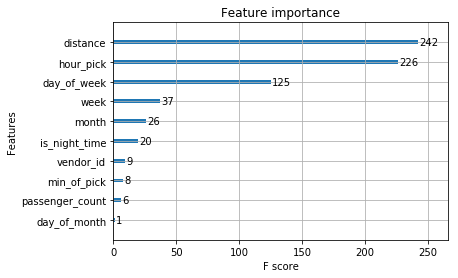

In [26]:
%matplotlib inline
xgb.plot_importance(model)